### Natural Language Understanding Challenge

To begin with - Due to the short timeframe, I wasn't able to refactor / beautify my code to the extent I would've liked. 

As I wrote more lines of code and iterated between several ideas, the complexity increased - and so my code might look a little off. Also, pardon the variable names if they are confusing. 

My production-grade code is usually a lot cleaner than this. :)

###       

We begin with data preparation and cleaning - the cornerstone of any NLP task

In [1]:
# Importing all necessary stuff

import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score, flat_accuracy_score, flat_classification_report

import eli5

#To compute time and resource allocation
import time
import tracemalloc

from keras.preprocessing.sequence import pad_sequences
import numpy as np

from keras.callbacks import EarlyStopping
from keras.models import Input, Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Embedding, Bidirectional, LSTM
from keras.layers.convolutional import Conv1D
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
class DataGetter():
    
    """ This is a class that loads and transforms data so it can be 
    immediately usable with just the appropriate method calls.
    
    Also has attributes that contain extracted data.
    """
    
    
    def __init__(self, filename):
        
        self.df = pd.read_json(filename)
        
        self.df['text'] = None
        self.df['intent'] = None
        self.df['entities'] = None
        self.df['training'] = None
        
        for index, row in self.df.iterrows():
            for key, value in self.df.iloc[index].sentences.items():
                self.df.iloc[index][key] = value
            
    
    
    def get_sentences(self):
        
        """ Returns a list of sentences in plain text"""
        
        self.sentences = self.df.text.tolist()
        return self.sentences



    def clean_and_tokenise(self):   
        
        """ Returns a list of tokenised and cleaned sentences"""
        
        self.get_sentences()
        
        """Removes '!', and '.' punctuations from sentence strings
        """
        for i, sent in enumerate(self.sentences):
            self.sentences[i] = re.sub('[.!]+', "", sent)            
            
        """ Splits string based on (- ' : , and ?). Deduced this list by 
            looking at the start-stop indices at various examples
        """
        self.sentences_tokenised = list(map(lambda x: re.split(" |(-)|'|(:)|(,)|(\?)", x), self.sentences))
        
        for i, sent in enumerate(self.sentences_tokenised):
            self.sentences_tokenised[i] = list(filter(None, sent))
            
        return self.sentences_tokenised
            
    
    def get_unique_entities(self):
        """Returns list of unique entities"""
        self.unique_ents = list(set([dict_['entity'] for sentence in self.df.entities for dict_ in sentence]))
        return self.unique_ents

        
    def get_unique_intents(self):
        """Returns list of unique intents"""
        self.unique_intents = list(set(self.df.intent))
        return self.unique_intents
        
    
    def get_entities(self):
        
        """Returns matching entity for every word"""
        
        self.clean_and_tokenise()
        
        self.entitites_start_stop = df.entities.apply(lambda x: [(w['start'], w['stop']) for w in x])
    
        self.entity_sequence = list(map(lambda x: ['O' for word in x], self.sentences_tokenised))
        
        for i, sent in enumerate(self.sentences_tokenised):
            for ent in self.df.iloc[i].entities:
                start = ent['start']
                stop = ent['stop']
                
                entity = ent['entity']
                
                self.entity_sequence[i][start:stop+1] = [entity for i in 
                                                         range(len(self.entity_sequence[i][start:stop+1]))]


        return self.entity_sequence

In [3]:
# Instantiating class
data = DataGetter('ChatbotCorpus.json')

# Getting the DataFrame object
df = data.df

# Getting unique entities in the corpus
unique_entities = data.get_unique_entities()

# Getting cleaned and tokenised sentences
sentences = data.clean_and_tokenise()

# Getting entities
entities = data.get_entities()

###    

It is at this point that I noticed that for some sentences, the 'start' and 'stop' values for their entities is one value higher. For example, if 'start' should be 3, it is 4. 

This misaligns the word-entity pair by one place. I had to fix this before proceeding.

For example, look at the sentence at index 33.

quiddestraße should have an entity value of StationStart but there is a mismatch by one place. In fact, all entities in this sentence are.

In [4]:
fmt = '{:<15} {:10}'
print(fmt.format("Entity Label", "Entity Text"),"\n","-"*30)

for i, j in zip(entities[33], sentences[33]):
    print(fmt.format(i, j))

Entity Label    Entity Text 
 ------------------------------
O               what      
O               s         
O               the       
O               shortest  
Criterion       way       
O               from      
O               quiddestraße
StationStart    to        
O               odeonsplatz
StationDest     ?         


###       

Let's redo entity extraction.

We mark words without entities as 'O', meaning 'no entity'

In [5]:

entities = list(map(lambda x: ['O' for word in x], sentences))

In [6]:
def fix_faulty(sentences, df, entities):
    
    """ Fixes faulty entity labelling (a data artifact)
    
    Args:
        sentences -> list of tokenised sentences
        df -> DataFrame generated from the input JSON
        entities -> list of entities for every word in every sentence
        
    Returns:
        entities -> list of entities for every word in every sentence (corrected)
        
    Raises:
        IndexError - when there is length mismatch between inputs
    """
    
    faulty_points = []

    for i, sent in enumerate(sentences):
        for ent in df.iloc[i].entities:
            start = ent['start']
            stop = ent['stop']
            text = ent['text']

            entity = ent['entity']

            text = re.split(" |(-)|'|(:)|(,)|(\?)", text)

            if not any(set(sentences[i][start:stop+1]) & set(text)):
                faulty_points.append(i)
                break

            len_entity = len(entities[i][start:stop+1])
            newlist = [entity] * len_entity
            entities[i][start:stop+1] = newlist


    for i in faulty_points:

        for ent in df.iloc[i].entities:

            start = ent['start'] - 1
            stop = ent['stop'] - 1

            entity = ent['entity']

            sentences[i][start:stop+1]

            len_entity = len(entities[i][start:stop+1])

            newlist = [entity] * len_entity
            entities[i][start:stop+1] = newlist
            
    return entities

In [7]:
entities = fix_faulty(sentences, df, entities)

###   

We fixed the problem now

In [8]:
fmt = '{:<15} {:10}'
print(fmt.format("Entity Label", "Entity Text"),"\n","-"*30)

for i, j in zip(entities[33], sentences[33]):
    print(fmt.format(i, j))

Entity Label    Entity Text 
 ------------------------------
O               what      
O               s         
O               the       
Criterion       shortest  
O               way       
O               from      
StationStart    quiddestraße
O               to        
StationDest     odeonsplatz
O               ?         


###      

Generating word, entity pairs for each sentence

In [9]:
def word_ent_pairs(sentences, entities):
    
    """ Generates (word, entity) pairs for each sentence.
    
    Args:
        sentences -> list of tokenised sentences
        entities -> list of entities for every word in every sentence
        
    Returns:
        sent_ents -> (word, entity) pair
        
    Raises:
        IndexError - if sentences and entities are not of the same size
  """
    
    sent_ents = []

    for i, sent in enumerate(sentences):

        word_ent = []
        for word, ent in zip(sent, entities[i]):
            word_ent.append((word, ent))

        sent_ents.append(word_ent)
    
    return sent_ents

In [10]:
sent_ents = word_ent_pairs(sentences, entities)

In [11]:
# Putting the above in a DataFrame

corpus = []

for sent in df.entities:
    
    for dict_ in sent:
        word = dict_['text']
        ent = dict_['entity']
    corpus.append((word, ent))
    
corpus_df = pd.DataFrame(corpus, columns=["word", "ent"])

#     

### 1) Named Entity Recognition

First we take a look at the count of entity labels.

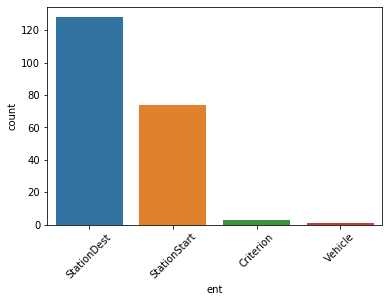

In [12]:
ent_plot = sns.countplot(corpus_df['ent'])
plt.xticks(rotation=45);

###     

And now the count of entities themselves (the top 10)

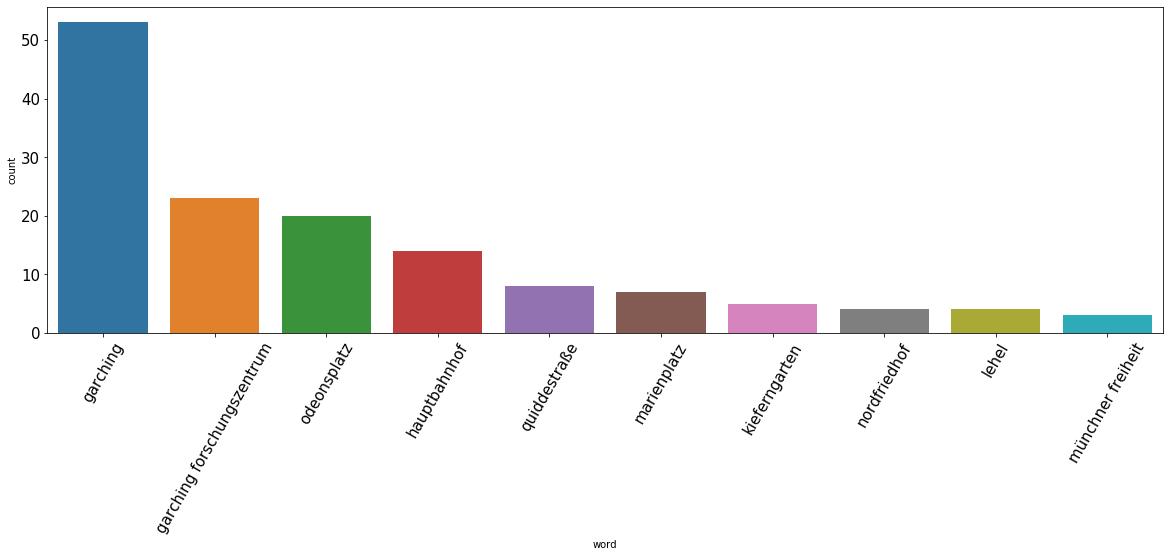

In [13]:
plt.figure(figsize=(20, 6));
word_plot = sns.countplot(corpus_df['word'], order=corpus_df['word'].value_counts()[:10].index)
plt.xticks(rotation=60, fontsize=15);
plt.yticks(fontsize=15);

###   

Since Named Entity Recognition is a sequence prediction task (if you preserve the order of your text), I decided to use a Conditional Random Field model, since these are well-suited for sequence labelling.

Also, I've worked on CRFs before for NER tasks, so it was the quickest way to solve this problem. 

Another option would have been an LSTM model (part of my solution for Intent Classification task below). 

If I disregarded the word order, I could have also used Random Forest or any of the popular classifiers, but this would involve generating features different from the ones I used for the CRF. Also, this approach would have almost certainly given inferior results, considering we throw away information. 

A CRF can be thought of as an extension of Logistic Regression for modelling sequential data. 

Logistic Regression predicts only a single class variable. CRFs can predict many variables that are interdependent. 

Naive Bayes, Logistic Regression and most other non-graphical classifiers predicts p(label|word).

CRFs are discriminative models (just like LogReg) which predict p(label|sequence). 

###      

We now generate features for our CRF model. I have modified this code from the one found in the sklearn_crfsuite documentation here - https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#features      

At first, I got 100% accuracy by following the method shown in the link. The results were too good to be true. I found out there's an error in the documentation, where the NER tag of the current word is introduced as a feature. 

I modified the code so this doesn't happen in our case. Traditional classifiers (like decision trees) worked with the original feature generator, but will not work here, due to my changes producing different features for train and test data. Could not implement a new one for those models given the deadline. 

##### 

In [14]:
def word2features_train(sent, i):
    
    """ Takes a list of sentences and generates features for every word in it 
    - for a training dataset
    
    Args: 
        sent -> a list of sentences containing the (word, entity) tuple
        i -> the index of the current word
            
    Returns: 
        features -> a dictionary of features for word at index i
    
    Raises:
        Fails if sent or i aren't in the expected format
    """
    
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),           
        'word[-3:]': word[-3:],                         # Substring of word
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),               # Flags if condition is met
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        nertag1 = sent[i-1][1]                           # NER tag of previous word
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:nertag': nertag1,
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        nertag1 = sent[i+1][1]                               # NER tag of next word
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': nertag1,
        })
    else:
        features['EOS'] = True

    return features


def word2features_test(sent, i):
    
    """ Takes a list of sentences and generates features for every word in it 
    - for a test dataset
    
    Args: 
        sent -> a list of sentences containing the (word, entity) tuple
        i -> the index of the current word
            
    Returns: 
        features -> a dictionary of features for word at index i
    
    Raises:
        Fails if sent or i aren't in the expected format
    """
    
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper()
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent, train):
    
    """ Takes a 'sent' object and generates features for each word in it
    
    Args:
        sent -> a list of sentences containing the (word, entity) tuple
        train -> True/False whether or not 'sent' is from the training data
    
    Returns:
        list of the outputs of word2features for a given 'sent' object
        
    Raises:
        Fails if 'sent' does not match the expected format
    """
    
    if train == True:
        return [word2features_train(sent, i) for i in range(len(sent))]
    else:
        return [word2features_test(sent, i) for i in range(len(sent))]

    
def sent2labels(sent):
    
    """ Takes a 'sent' object and extracts entity label for each word in it
    
    Args:
        sent -> a list of sentences containing the (word, entity) tuple
        
    Returns:
        list of the entity labels for each word in a 'sent' object
        
    Raises:
        Fails if 'sent' does not match the expected format
    """
    
    return [label for token, label in sent]


In [15]:
# Generating train and test vectors to feed into the CRF model

train_index = df[df.training == True].index.tolist()
test_index = df[df.training == False].index.tolist()


sent_ents_train = [sent_ents[i] for i in train_index]

sent_ents_test = [sent_ents[i] for i in test_index]


X_train = [sent2features(s, train=True) for s in sent_ents_train]
y_train = [sent2labels(s) for s in sent_ents_train]


X_test = [sent2features(s, train=False) for s in sent_ents_test]
y_test = [sent2labels(s) for s in sent_ents_test]

####    

In [16]:
# Fitting our CRF model

tracemalloc.start()

start = time.time()

crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)


crf.fit(X_train, y_train)

pred_crf = crf.predict(X_test)

end = time.time()

print("\n\n\x1b[31mCurrent memory usage: %d bytes \nPeak memory usage: %d bytes\x1b[0m\n\n" % tracemalloc.get_traced_memory())

print("\n\n\x1b[31mThe CRF model took {} seconds to run\x1b[0m\n\n".format(round(end-start, 2)))

report_ner = flat_classification_report(y_pred=pred_crf, y_true=y_test)

f1_score_ner = flat_f1_score(y_test, pred_crf, average='weighted')

accuracy_ner = flat_accuracy_score(y_test, pred_crf)

print(report_ner)
print("\nValidation Accuracy score: ", round(accuracy_ner, 2))
print("\nValidation F1 score: ", round(f1_score_ner, 2))



Current memory usage: 226388 bytes 
Peak memory usage: 239104 bytes




The CRF model took 0.23 seconds to run


              precision    recall  f1-score   support

   Criterion       1.00      0.94      0.97        34
        Line       1.00      1.00      1.00         1
           O       0.97      0.99      0.98       508
 StationDest       0.95      0.99      0.97        78
StationStart       1.00      0.90      0.95       145
     Vehicle       1.00      1.00      1.00        45

    accuracy                           0.97       811
   macro avg       0.99      0.97      0.98       811
weighted avg       0.97      0.97      0.97       811


Validation Accuracy score:  0.97

Validation F1 score:  0.97


We get an overall flattened F1 score of 0.97, which is decent for our small dataset. Overall accuracy is also 97%. 

Also, we see the breakdown of our metrics by entity type. 

StartDest has the worst precision at 0.95 (relatively higher false positives) while Criterion has the worst recall at 0.94 (relatively lower true positives)

###   

CRFs allow us to visualise the transition scores and important features by their weights, which we do here - 

In [17]:
eli5.show_weights(crf, top=10)

For example, we see that the likelihood of a Vehicle entity following a Criterion entity is quite high. 

For StationStart entities, we see that the top weighted feature is -1:word.lower():from, which is the lowercase of the previous word.

This means, for a current word, the model gets most clues about whether or not to predict StationStart as the entity from looking at the previous word.

###    

To test the usefulness of our model, we have to try it on new data   

In [18]:
def sample_ent_test(sample_text):
    
    """ Given a string input, formats and generates an NER prediction 
    for it using our trained model.
    
    Args:
        sample_text -> String of a sample sentence
        
    Returns:
        pred_crf -> NER prediction from our CRF model
        sample_text -> Processed string from the input
        
    Raises:
        Fails if sample_text is not a string
    """
    
    sample_text = re.sub('[.!]+', "", sample_text)
    sample_text = re.split(" |(-)|'|(:)|(,)|(\?)", sample_text)
    sample_text = [(word, None) for word in sample_text if (word != None and word != "")]
    X_test_sample = [sent2features(sample_text, train=False)]
    pred_crf = crf.predict(X_test_sample)
    
    sample_text = [word[0] for word in sample_text]
    
    return pred_crf, sample_text


sample_text = "Can you tell me the shortest route from Whitefield to Majestic?"

pred_crf_sample, sample_text = sample_ent_test(sample_text)


fmt = '{:<15} {:10}'
print(fmt.format("Entity Label", "Entity Text"),"\n","-"*30)

for i, j in zip(pred_crf_sample[0], sample_text):
    print(fmt.format(i, j))


Entity Label    Entity Text 
 ------------------------------
O               Can       
O               you       
O               tell      
O               me        
O               the       
Criterion       shortest  
O               route     
O               from      
StationStart    Whitefield
O               to        
StationDest     Majestic  
O               ?         


####         

As we see, it performs alright in this case, where we have changed the setting from Germany to Bangalore. 

Let's take a look at another case, this time using a Criterion words never encountered in the training dataset.

In [19]:
sample_text = "Can you tell me the craziest route from Indiranagar to Majestic?"

pred_crf_sample, sample_text = sample_ent_test(sample_text)


fmt = '{:<15} {:10}'
print(fmt.format("Entity Label", "Entity Text"),"\n","-"*30)

for i, j in zip(pred_crf_sample[0], sample_text):
    print(fmt.format(i, j))

Entity Label    Entity Text 
 ------------------------------
O               Can       
O               you       
O               tell      
O               me        
O               the       
Criterion       craziest  
O               route     
O               from      
StationStart    Indiranagar
O               to        
StationDest     Majestic  
O               ?         


####       

Still works! 

The trick is that, during training, our CRF model looks at the ending of the word marked as Criterion (usually ending in "-est") and correctly deduces a brand new, unseen word to be a Criterion if it ends "-est" in a similar setting.

Let's now try replacing "craziest" with complete gibberish.

In [20]:
sample_text = "Can you tell me the oihioahdwf route from Indiranagar to Majestic?"

pred_crf_sample, sample_text = sample_ent_test(sample_text)

fmt = '{:<15} {:10}'
print(fmt.format("Entity Label", "Entity Text"),"\n","-"*30)

for i, j in zip(pred_crf_sample[0], sample_text):
    print(fmt.format(i, j))

Entity Label    Entity Text 
 ------------------------------
O               Can       
O               you       
O               tell      
O               me        
O               the       
O               oihioahdwf
O               route     
O               from      
StationStart    Indiranagar
O               to        
StationDest     Majestic  
O               ?         


####              

It fails now, because the new gibberish word has a very different ending. 


In your mailer, you had asked me to think about edge cases where the input is in different languages. "How are you aaj?"    

In theory, CRFs are capable of understanding the context based on word order and making predictions on new words.

To this end, my best guess is that we can implement better, more informative features in our CRF model AND procure a lot more training data.

Looking at more data will most likely give our model more confidence to make a bolder prediction. 

###      

### 2) Intent Categorisation

First we take a look at the count of the different entities we have in our data

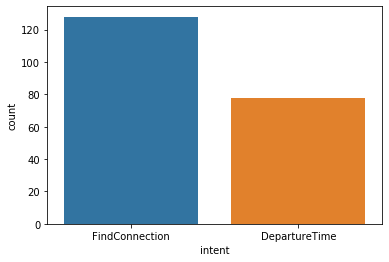

In [21]:
intent_plot = sns.countplot(df.intent)

We see there are just two intents and 'FindConnection' has about double the support of 'DepartureTime'

Since I didn't have time to run many experiments, I straightaway decided to implement a fairly simple Convolutional-LSTM neural network architecture to build a classifier, as I've used this extensively at work and it gives good results.   

The CNN layers attempt to capture adjacent words with the use of convolutional windows (one-dimensional, in our case). 

The LSTM layer attempts to iterate through a sequence of words and labels while preserving state internally (keeps track of what it has seen before).  

Also, I used just the vanilla Keras embeddings instead of more suitable ones like Word2Vec or FastText. I did this in favour of simplicity. I didn't use pretrained SpaCy models either for the same reason.   

I would've liked to try a simpler model like RandomForest or even Naive Bayes first as a baseline.   

###     

In [22]:
# Splitting train and test data based on the 'training' flag

df_train = df[df.training == True]
df_test = df[df.training == False]

In [23]:
# Finding the length of each sentence and the overall mean length

len_sents = []

for sent in sentences:
    len_sents.append(len(sent))

mean_len = sum(len_sents)/len(len_sents)

In [24]:
# Finding the list of all unique words

words = list(set([word for sent in sentences for word in sent]))

In [25]:
# The last word will be 'PAD', to account for the variability in length 
# (since we feed in a fixed-length tensor to our model)
words.append("PAD")

# The number of unique words 
n_words = len(words)

# Mapping each unique word to a unique ID
word2idx = {w: i for i, w in enumerate(words)}

In [26]:
# Defining the maximum length of our input tensor for a sentence

max_len = 20

###     

We encode FindConnection as 0 and DepartureTime as 1

In [27]:
intent_encoded = {'0': 'FindConnection', '1': 'DepartureTime'}

In [28]:
# Creating training and test tensors

X_train_intent = [[word2idx[w[0]] for w in sent] for sent in sent_ents_train]

X_train_intent = pad_sequences(maxlen=max_len, sequences=X_train_intent, 
                               padding="post", value=n_words - 1)

y_train_intent = np.zeros((len(X_train_intent), 2))



X_test_intent = [[word2idx[w[0]] for w in sent] for sent in sent_ents_test]

X_test_intent = pad_sequences(maxlen=max_len, sequences=X_test_intent, 
                              padding="post", value=n_words - 1)

y_test_intent = np.zeros((len(X_test_intent), 2))


for i in range(len(X_train_intent)):
    y_train_intent[i,:] = [1.0, 0.0] if df_train.iloc[i].intent == 'FindConnection' else [0.0, 1.0]

for i in range(len(X_test_intent)):
    y_test_intent[i,:] = [1.0, 0.0] if df_test.iloc[i].intent == 'FindConnection' else [0.0, 1.0]

In [29]:
# Setting some hyperparameters for our Convolutional-LSTM model

batch_size = 32
nb_epochs = 100

###     

We use the Keras functional API to build our model.

In [30]:
input_ = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input_)

model = Conv1D(32, kernel_size=3, activation='elu', padding='same')(model)
model = Dropout(rate=0.3)(model)

model = Conv1D(16, kernel_size=5, activation='elu', padding='same')(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = Dense(16, activation='tanh')(model)

model = Flatten()(model)
out = Dense(2, activation="softmax")(model)  # softmax output layer
model = Model(input_, out)

###     

Our final model architecture looks like so

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 50)            9000      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 32)            4832      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 16)            2576      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 200)           93600     
_________________________________________________________________
dense_1 (Dense)              (None, 20, 16)            3216      
__________

###    

Now commencing model compilation and training

In [32]:
tracemalloc.start()

start = time.time()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])


history = model.fit(X_train_intent, y_train_intent,
              batch_size=batch_size,
              shuffle=True,
              epochs=nb_epochs,
              validation_data=(X_test_intent, y_test_intent),
              callbacks=[EarlyStopping(min_delta=0.00025, patience=2)],
                verbose=0)

end = time.time()

In [33]:
epochs = len(history.history['loss'])


print("\n\n\x1b[31mCurrent memory usage: %d bytes \nPeak memory usage: %d bytes\x1b[0m\n\n" % tracemalloc.get_traced_memory())


print("\n\x1b[31mCNN-LSTM model took {} seconds to train with {} epochs\x1b[0m".format(round(end-start, 2), epochs))



Current memory usage: 39951874 bytes 
Peak memory usage: 41782881 bytes



CNN-LSTM model took 20.01 seconds to train with 59 epochs


###      

Prediction

In [34]:
pred_intent = model.predict(X_test_intent)


pred_vals = [np.argmax(val) for val in pred_intent]
y_vals = [np.argmax(val) for val in y_test_intent]

###     

Evaluating the model

In [35]:
accuracy_intent = accuracy_score(pred_vals, y_vals)

f1_score_intent = f1_score(pred_vals, y_vals)

report_intent = classification_report(pred_vals, y_vals)

print("Validation accuracy score: ", round(accuracy_intent, 2))

print("\nValidation F1 score: ", round(f1_score_intent,2))

print("\n", "0 = 'FindConnection', 1 = 'DepartureTime \n\n", report_intent)

Validation accuracy score:  0.96

Validation F1 score:  0.95

 0 = 'FindConnection', 1 = 'DepartureTime 

               precision    recall  f1-score   support

           0       0.94      1.00      0.97        67
           1       1.00      0.90      0.95        39

    accuracy                           0.96       106
   macro avg       0.97      0.95      0.96       106
weighted avg       0.96      0.96      0.96       106



###     

Plotting our loss and val loss against each epoch, we get this chart.

As the training progresses, validation loss begins to exceed training loss by a small margin. Hence, we are likely not overfitting.

Training automatically stops as validation loss stagnates or starts rising.

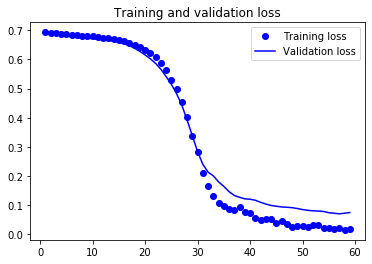

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###    

Testing our new intent classifier with our own examples

In [37]:
def sample_intent_test(sample_intent):
    
    """ Given a string input, formats and generates an intent
    classification prediction for it using our trained model.
    
    Args:
        sample_text -> String of a sample sentence
        
    Returns:
        pred_crf -> Intent classification prediction from our CRF model
        
    Raises:
        AssertionError -> if length of tokenised and formatted string
        is greater than 20
        
        Fails if sample_text is not a string
    """

    sample_intent = re.sub('[.!]+', "", sample_intent)
    sample_intent = re.split(" |(-)|'|(:)|(,)|(\?)", sample_intent)
    sample_intent = [word for word in sample_intent if word != None]
    
    assert len(sample_intent) <= 20

    X_sample_intent = np.zeros((1, len(sample_intent)))

    for i, word in enumerate(sample_intent):
        if word not in word2idx.keys():
            continue
        X_sample_intent[:,i] = word2idx[word]

    X_sample_intent = pad_sequences(maxlen=max_len, sequences=X_sample_intent, 
                                   padding="post", value=n_words - 1)    

    pred_sample_intent = model.predict(X_sample_intent)
    pred_val = np.argmax(pred_sample_intent)
    
    return pred_val

In [38]:
sample_intent = "Can you tell me the quickest way to go from Bangalore to London?"

pred_val = sample_intent_test(sample_intent)

intent_encoded[str(pred_val)]

'FindConnection'

###     

It works. Let's try a less polite request.

In [39]:
sample_intent = "Dude, tell me the quickest way to go from Delhi to Mumbai"

pred_val = sample_intent_test(sample_intent)

intent_encoded[str(pred_val)]

'FindConnection'

###    

Still works. Let's try to find out when our ride leaves.

In [40]:
sample_intent = "Tell me the next bus from Bangalore"

pred_val = sample_intent_test(sample_intent)

intent_encoded[str(pred_val)]

'DepartureTime'

In [41]:
sample_intent = "When is the next bus from Chennai leaving?"

pred_val = sample_intent_test(sample_intent)

intent_encoded[str(pred_val)]

'DepartureTime'

###     

All these test cases mirror the word order of the examples in our training data. 

However, if we go off-script, and start throwing in relevant queries which aren't similar to the ones in the training data, the model gets it wrong sometimes. It's a hit or miss. 

More data and more fine-tuning will likely help alleviate this problem to a good extent.

In [42]:
sample_intent = "What time is my Uber leaving?"

pred_val = sample_intent_test(sample_intent)

intent_encoded[str(pred_val)]

'DepartureTime'

###    

### That's a wrap!